# Replication of Newman *et al.* (2015) *in-vitro* optoclamp

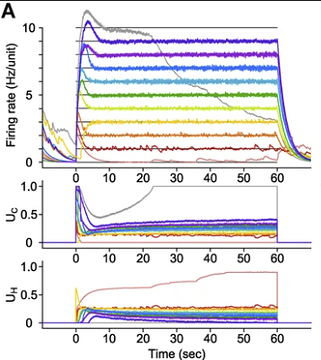

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import brian2 as b2
import cleo

b2.prefs.codegen.target = 'numpy'

WARNING    /home/kyle/mambaforge/envs/cleo12/lib/python3.12/site-packages/attr/_make.py:918: RuntimeWarning: Running interpreter doesn't sufficiently support code object introspection.  Some features like bare super() or accessing __class__ will not work with slotted classes.
  set_closure_cell(cell, cls)
 [py.warnings]


## Balanced E/I network
from [Neuronal Dynamics](https://neuronaldynamics-exercises.readthedocs.io/en/latest/_modules/neurodynex3/brunel_model/LIF_spiking_network.html#simulate_brunel_network)

In [2]:
from random import sample

b2.defaultclock.dt = 0.1 * b2.ms
b2.prefs.codegen.target = 'cython'

N_Excit=1000
N_Inhib=None  # None = N_Excit / 4
N_extern=1000
connection_probability=0.1
w0=0.65 * b2.mV
g=6
synaptic_delay=1.5 * b2.ms
poisson_input_rate=8.2 * b2.Hz
w_external=None
w_external=0.1 * b2.mV
v_rest=-70 * b2.mV
v_reset=-60 * b2.mV
firing_threshold=-50 * b2.mV
membrane_time_scale=20 * b2.ms
abs_refractory_period=2 * b2.ms
monitored_subset_size=100
random_vm_init=True
"""
Fully parametrized implementation of a sparsely connected network of LIF neurons (Brunel 2000)

Args:
    N_Excit (int): Size of the excitatory popluation
    N_Inhib (int): optional. Size of the inhibitory population.
        If not set (=None), N_Inhib is set to N_excit/4.
    N_extern (int): optional. Number of presynaptic excitatory poisson neurons. Note: if set to a value,
        this number does NOT depend on N_Excit and NOT depend on connection_probability (this is different
        from the book and paper. Only if N_extern is set to 'None', then N_extern is computed as
        N_Excit*connection_probability.
    connection_probability (float): probability to connect to any of the (N_Excit+N_Inhib) neurons
        CE = connection_probability*N_Excit
        CI = connection_probability*N_Inhib
        Cexternal = N_extern
    w0 (float): Synaptic strength J
    g (float): relative importance of inhibition. J_exc = w0. J_inhib = -g*w0
    synaptic_delay (Quantity): Delay between presynaptic spike and postsynaptic increase of v_m
    poisson_input_rate (Quantity): Poisson rate of the external population
    w_external (float): optional. Synaptic weight of the excitatory external poisson neurons onto all
        neurons in the network. Default is None, in that case w_external is set to w0, which is the
        standard value in the book and in the paper Brunel2000.
        The purpose of this parameter is to see the effect of external input in the
        absence of network feedback(setting w0 to 0mV and w_external>0).
    v_rest (Quantity): Resting potential
    v_reset (Quantity): Reset potential
    firing_threshold (Quantity): Spike threshold
    membrane_time_scale (Quantity): tau_m
    abs_refractory_period (Quantity): absolute refractory period, tau_ref
    monitored_subset_size (int): nr of neurons for which a VoltageMonitor is recording Vm
    random_vm_init (bool): if true, the membrane voltage of each neuron is initialized with a
        random value drawn from Uniform(v_rest, firing_threshold)
    sim_time (Quantity): Simulation time

Returns:
    (rate_monitor, spike_monitor, voltage_monitor, idx_monitored_neurons)
    PopulationRateMonitor: Rate Monitor
    SpikeMonitor: SpikeMonitor for ALL (N_Excit+N_Inhib) neurons
    StateMonitor: membrane voltage for a selected subset of neurons
    list: index of monitored neurons. length = monitored_subset_size
"""
if N_Inhib is None:
    N_Inhib = int(N_Excit / 4)
if N_extern is None:
    N_extern = int(N_Excit * connection_probability)
if w_external is None:
    w_external = w0

J_excit = w0
J_inhib = -g * w0

lif_dynamics = """
dv/dt = -(v-v_rest) / membrane_time_scale : volt (unless refractory)"""

neurons = b2.NeuronGroup(
    N_Excit + N_Inhib,
    model=lif_dynamics,
    threshold="v>firing_threshold",
    reset="v=v_reset",
    refractory=abs_refractory_period,
    method="linear",
)
if random_vm_init:
    neurons.v = (
        np.random.uniform(
            v_rest / b2.mV, high=firing_threshold / b2.mV, size=(N_Excit + N_Inhib)
        )
        * b2.mV
    )
else:
    neurons.v = v_rest
excitatory_population = neurons[:N_Excit]
inhibitory_population = neurons[N_Excit:]

exc_synapses = b2.Synapses(
    excitatory_population,
    target=neurons,
    on_pre="v += J_excit",
    delay=synaptic_delay,
)
exc_synapses.connect(p=connection_probability)

inhib_synapses = b2.Synapses(
    inhibitory_population,
    target=neurons,
    on_pre="v += J_inhib",
    delay=synaptic_delay,
)
inhib_synapses.connect(p=connection_probability)

external_poisson_input = b2.PoissonInput(
    target=neurons,
    target_var="v",
    N=N_extern,
    rate=poisson_input_rate,
    weight=w_external,
)

# collect data of a subset of neurons:
monitored_subset_size = min(monitored_subset_size, (N_Excit + N_Inhib))
idx_monitored_neurons = sample(range(N_Excit + N_Inhib), monitored_subset_size)
# rate_monitor = b2.PopulationRateMonitor(neurons)
# record= some_list is not supported? :-(
spike_monitor = b2.SpikeMonitor(neurons, record=idx_monitored_neurons)
# voltage_monitor = b2.StateMonitor(neurons, "v", record=idx_monitored_neurons)

net = b2.Network(
    neurons,
    exc_synapses,
    inhib_synapses,
    external_poisson_input,
    # rate_monitor,
    # spike_monitor,
    # voltage_monitor,
)

# net.run(3 * b2.second)
# plt.scatter(spike_monitor.t / b2.ms, spike_monitor.i, s=0.5)
# plt.xlim(0, 10000)

In [3]:
sim = cleo.CLSimulator(net)

WARNING    /home/kyle/Dropbox (GaTech)/projects/cleo/cleo/utilities.py:91: RuntimeWarning: invalid value encountered in divide
  c = (xyz_end - xyz_start) / cyl_length  # unit vector in direction of cylinder
 [py.warnings]


(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (mm)', ylabel='y (mm)', zlabel='z (mm)'>)

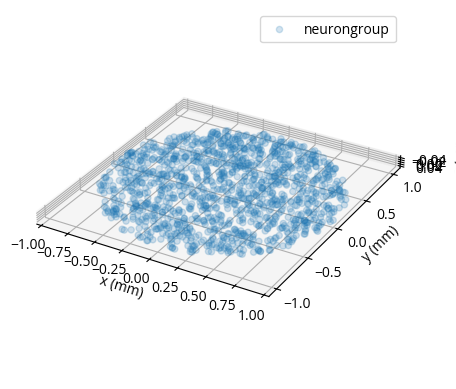

In [4]:
cleo.coords.assign_coords_rand_cylinder(neurons, [0, 0, 0], [0, 0, 0], 1)
cleo.viz.plot(neurons, xlim=[-1, 1], axis_scale_unit=b2.mm)

## Multi-electrode array (MEA)
Spacing appears to be 200 μm.

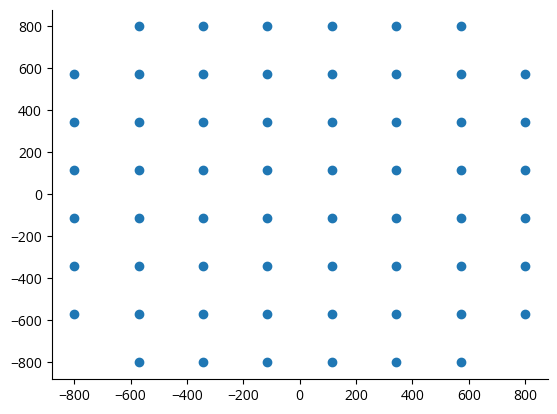

In [5]:
space = 200 * b2.um
n_side = 8
radius = space * n_side / 2
x, y = np.meshgrid(np.linspace(-radius, radius, n_side), np.linspace(-radius, radius, n_side))
y.shape
xy = np.column_stack([x.ravel(), y.ravel()]) * b2.meter
xy = np.delete(xy, [0, n_side - 1, -n_side, -1], 0) * b2.meter
plt.scatter(xy[:, 0] / b2.um, xy[:, 1] / b2.um)
# xy

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (um)', ylabel='y (um)', zlabel='z (um)'>)

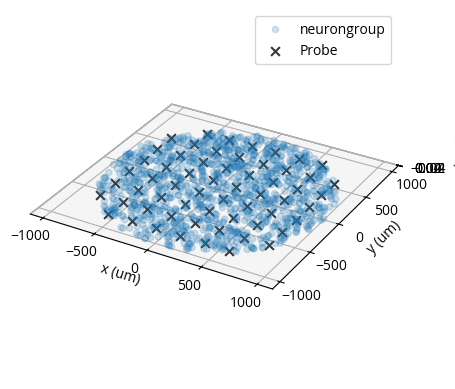

In [6]:
xyz = np.column_stack([xy, np.zeros(xy.shape[0])]) * b2.meter
spikes = cleo.ephys.SortedSpiking(r_perfect_detection=40 * b2.um, r_half_detection=80 * b2.um)
probe = cleo.ephys.Probe(coords=xyz, signals=[spikes])
sim.inject(probe, neurons)
cleo.viz.plot(neurons, devices=[probe])

(0.0, 10000.0)

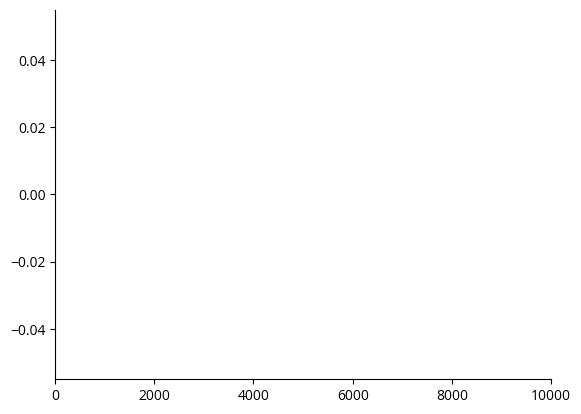

In [7]:
sim.set_io_processor(cleo.ioproc.RecordOnlyProcessor(sample_period_ms=1))
# sim.run(.1 * b2.second)
plt.scatter(spikes.t_ms, spikes.i, s=0.5)
plt.xlim(0, 10000)

## Optogenetics

In [8]:
blue = cleo.light.Light(
    name='blue light',
    coords=[0, 0, -250] * b2.um,
    light_model=cleo.light.Koehler(radius=1 * b2.mm),
    wavelength=465 * b2.nmeter,
)
yellow = cleo.light.Light(
    name='yellow light',
    coords=[0, 0, -250] * b2.um,
    light_model=cleo.light.Koehler(radius=1 * b2.mm),
    wavelength=590 * b2.nmeter,
)
sim.inject(blue, neurons).inject(yellow, neurons)

CLSimulator(io_processor=<cleo.ioproc.base.RecordOnlyProcessor object at 0x7f1574f3c7d0>, devices={Light(sim=..., name='Light', save_history=True, value=array([0.]), light_model=Koehler(radius=1. * mmetre, zmax=0.5 * mmetre), wavelength=0.59 * umetre, direction=array([0., 0., 1.]), max_Irr0_mW_per_mm2=None, max_Irr0_mW_per_mm2_viz=None), Probe(sim=..., name='Probe', save_history=True, signals=[SortedSpiking(name='SortedSpiking', brian_objects={<SpikeMonitor, recording from 'spikemonitor_1'>}, probe=..., r_perfect_detection=40. * umetre, r_half_detection=80. * umetre, cutoff_probability=0.01)], probe=NOTHING)})

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (um)', ylabel='y (um)', zlabel='z (um)'>)

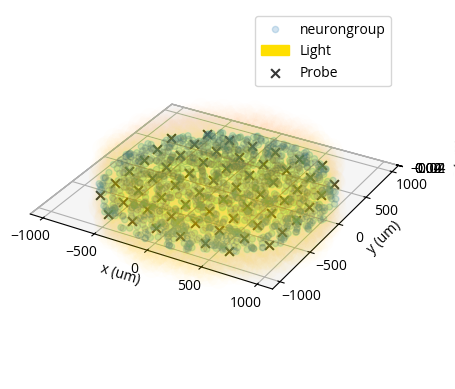

In [10]:
cleo.viz.plot(sim=sim)

In [ ]:
sim.inject(cleo.opto.chr2_h134r_4s(), neurons)
sim.inject(cleo.opto.enphr3(), neurons)


## PI control

In [ ]:
class Controller(cleo.ioproc.LatencyIOProcessor):
    def __init__(self, sample_period_ms=4):
        super().__init__(sample_period_ms=sample_period_ms)
        self.fre = cleo.ioproc.FiringRateEstimator(
            tau_ms=2500, sample_period_ms=sample_period_ms
        )
        self.Ts = 0.01 * b2.second  # control period (round-trip time)
        self.Ti = 1 * b2.second  # integral time constant
        self.Kp = 0.1  # proportional gain
        self.u = 0
        self.fref = 0
        self.ef_prev = 0
        self.Δ = 0.25  # overlap between ChR2 and eNpHR3
        self.UC = []
        self.UH = []

    def process(self, state_dict, t_sample_ms):
        _, _, spike_counts = state_dict['Probe']['SortedSpiking']
        f = self.fre.compute_output(spike_counts, t_sample_ms)
        ef = self.fref - f # error in firing rate
        self.u = self.u + self.Kp * (ef - self.ef_prev + self.Ts / self.Ti * ef)
        UC = self.u + self.Δ
        UH = -self.u + self.Δ

        self.ef_prev = ef